# Exercise 3.4: MLP in PyTorch

Advanced Machine Learning for KCS

by Stefan Heinrich, Stella Grasshof, Laura Weihl
with material by Kevin Murphy

All info and static material: https://learnit.itu.dk/course/view.php?id=3021295

-------------------------------------------------------------------------------

## MLP on MNIST using PyTorch

In [1]:
# Standard Python libraries
from __future__ import absolute_import, division, print_function, unicode_literals

from IPython import display
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms


### Load the data

In [2]:
BATCH_SIZE = 32

# transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

# Create a dataloader for Pytorch training
# download and load training dataset
trainset = torchvision.datasets.MNIST(root='../data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

# download and load testing dataset
testset = torchvision.datasets.MNIST(root='../data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)

### Build the model

In [3]:
def get_output_shape(layer, img_size):
    return layer(torch.rand(*(img_size))).data.shape

class MNIST_model(nn.Module):
  def __init__(self, img_size, fc1_out, class_out):
      super(MNIST_model, self).__init__()

      self.linear_layer_1 = nn.Linear(in_features=img_size*img_size, out_features=fc1_out)
      self.linear_layer_2 = nn.Linear(in_features=fc1_out, out_features=class_out)

  def forward(self, img):

    # we flatten the 2D image into one long array
    # Start_dim = 1 because we pass the batches
    img = img.flatten(start_dim=1)

    x = self.linear_layer_1(img)
    x = F.relu(x)

    x = self.linear_layer_2(x)
    x = F.softmax(x, dim=1)

    return x

### Train the model

In [4]:
# Define hyperparameters
learning_rate = 0.001
momentum = 0.9
epochs = 5

# Setup for training
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu")
img_size = trainloader.dataset.data.shape[1]
class_out = trainloader.dataset.targets.unique().size()[0]
model = MNIST_model(img_size, 128, class_out)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# Training loop

def get_accuracy(logit, target, batch_size):
    # compute accuracy
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

for epoch in range(epochs):
  # Put the model in training mode
  model = model.train()

  train_running_loss = 0.0
  train_acc = 0.0
  for idx, (images, labels) in enumerate(trainloader):
    images = images.to(device)
    labels = labels.to(device)

    # loss and optimiser definitions!
    logits = model(images)
    loss = criterion(logits, labels)
    optimizer.zero_grad()

    loss.backward()

    # update model params
    optimizer.step()

    train_running_loss += loss.detach().item()
    train_acc += get_accuracy(logits, labels, BATCH_SIZE)

  print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / idx, train_acc/idx))

model = model.eval()
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, 1)

print(f"Test Accuracy: {test_acc/i}, in epoch: {epoch}")

Epoch: 0 | Loss: 2.2564 | Train Accuracy: 26.26
Epoch: 1 | Loss: 1.9730 | Train Accuracy: 59.61
Epoch: 2 | Loss: 1.7847 | Train Accuracy: 73.02
Epoch: 3 | Loss: 1.7463 | Train Accuracy: 74.37
Epoch: 4 | Loss: 1.7223 | Train Accuracy: 76.63
Test Accuracy: 80.6980698069807, in epoch: 4


### Prediction and visualisation

In [5]:
model = model.eval()

hist = {
          0: {i:0 for i in range(10)},
          1: {i:0 for i in range(10)},
          2: {i:0 for i in range(10)},
          3: {i:0 for i in range(10)},
          4: {i:0 for i in range(10)},
          5: {i:0 for i in range(10)},
          6: {i:0 for i in range(10)},
          7: {i:0 for i in range(10)},
          8: {i:0 for i in range(10)},
          9: {i:0 for i in range(10)}
        }

logits = []

for (images, labels) in testloader:
  images = images.to(device)
  labels = labels.to(device)
  outputs = model(images)
  logits.append(outputs.tolist()[0])
  pred = torch.argmax(outputs).item()
  hist[labels[0].item()][pred] += 1

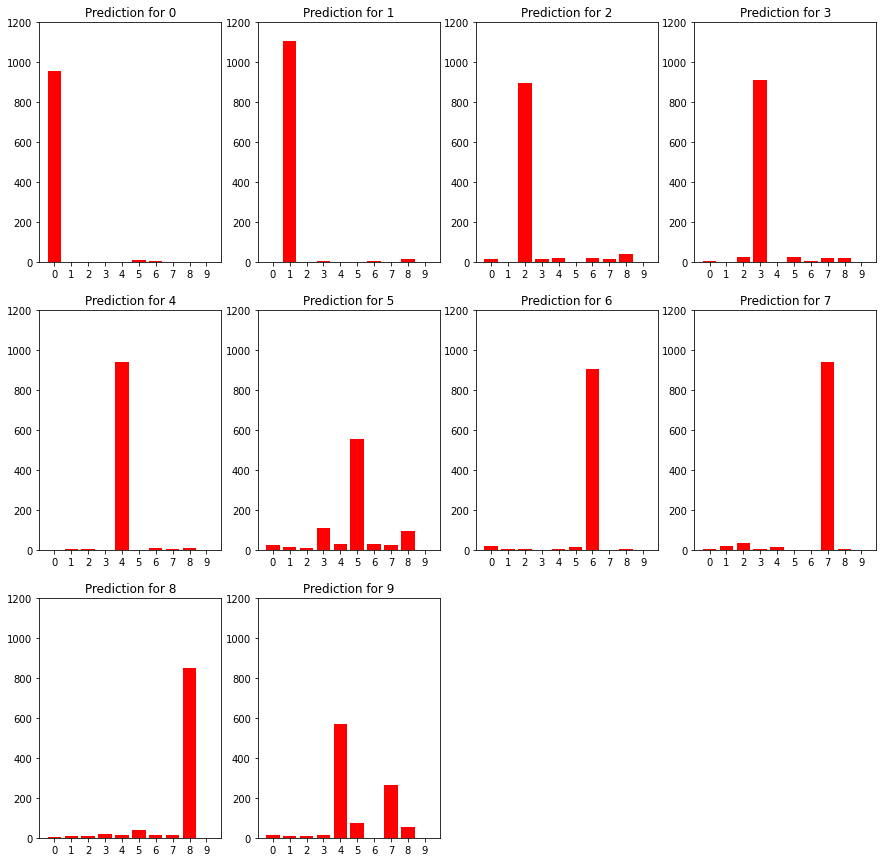

In [6]:
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
for idx, (key, val) in enumerate(hist.items()):
  ax = fig.add_subplot(3, 4, idx+1)
  ax.bar(list(val.keys()), val.values(), color='r')
  ax.set_title(f"Prediction for {key}")
  ax.set_xticks(range(0,10))
  ax.set_ylim(0, 1200)

plt.show()

##### a - Get familiar with PyTorch. Test different optimizers and loss functions on the IRIS and MNIST data. What is the impact of hyperparameters for both performance and speed?
Different hyperparameters can affect both performance and speed by alot. 

xx is a lot more computational heavy making the speed worse compared to yy. However it can also more accurately calculate the loss.

Some activation functions are at a higher risk of leading to vanishing gradient due to the gradient valeus coming close to zero for many values: sigmoid and tanh.
softmax and ReLU doesn't suffer from this?

##### b - Test different activation functions. How are loss function and activation function dependent?
The loss function describes how we do gradient descent and thereby how we try to reach the global (or local) minima.

The activation function affects how we go from layer to layer. Therefore these also affect the backpropagation, which is where it affects the loss function.

During backpropagation the activation function is differentiated to find the gradient descent.